In [5]:
# Array and image processing toolboxes
import numpy as np 
import skimage
import skimage.io
import skimage.color
import skimage.transform

import matplotlib.pyplot as plt
%matplotlib inline  

In [6]:
DIMX  = 256
DIMY  = 256
DIMZ  = 256

In [7]:
# Read the volume
fname = 'data/image_3d/bucky_256.tif'
image = skimage.io.imread(fname)
image = np.transpose(image, [1, 2, 0])

print(image.shape)

##### Doing projection
alpha_path = None
if alpha_path==None: 
    # Generate random alpha value
    # lut = np.random.uniform(low=0, high=256, size=256).astype(np.uint8)
    lut = np.linspace(start=0, stop=10, num=256, endpoint=False).astype(np.uint8)
    #lut = 128.0 * np.ones_like(lut)
    # lut[0] = 0.0
    # lut[0] = 0.1
    # lut[1] = 0.6
    # ..
    # lut[255] = 0.2
else:
    pass

(256, 256, 256)


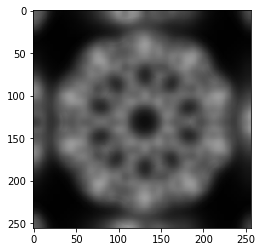

In [10]:
color_s = image.copy() 					# Construct the per-voxel color (or resample _s)
alpha_s = lut[color_s.astype(np.uint8)].astype(np.uint8)	# Construct the per-voxel alpha (or resample _s)

color_h = np.zeros_like(image).astype(np.float32)
alpha_h = np.zeros_like(image).astype(np.float32)


color = np.zeros((DIMY, DIMX), dtype=np.float32)
alpha = np.zeros((DIMY, DIMX), dtype=np.float32)

isBackToFront = True
if isBackToFront:
    # Back-to-front compositing
    for i in range(DIMZ-1, -1, -1): # March from 0 to 255
        ci = color_s[:,:,i]/255.0
        ai = alpha_s[:,:,i]/255.0
        # ch_i = ci + (1-ai)*ch_ip1
        # ah_i = ai + (1-ai)*ah_ip1
        if i==DIMZ-1: # the backest slide
            color_h[:,:,i] = ci
            alpha_h[:,:,i] = ai
        else:
            color_h[:,:,i] = ai*ci + (1-ai)*color_h[:,:,i+1]
            alpha_h[:,:,i] = ai    + (1-ai)*alpha_h[:,:,i+1]
else: 
    pass
    # Front-to-back compositing
    for i in range(0, 256, 1): # March from 255 to 0
        ci = color_s[:,:,i]/255.0
        ai = alpha_s[:,:,i]/255.0
        # ch_i = (1-ahim1)*ci + ch_im1
        # ah_i = (1-ahim1)*ai + ah_im1
        if i==0: # the backest slide
            color_h[:,:,i] = ai*ci
            alpha_h[:,:,i] = ai
        else:
            color_h[:,:,i] = (1-alpha_h[:,:,i-1])*ai*ci + color_h[:,:,i-1]
            alpha_h[:,:,i] = (1-alpha_h[:,:,i-1])*ai + alpha_h[:,:,i-1]

color_h = 255*color_h
# Create the img2d image
img2d = np.zeros((DIMY, DIMX, 3), dtype=np.uint8)
color = skimage.color.gray2rgb(color_h[:,:,0].astype(np.uint8))
img2d = color.copy()
plt.imshow(img2d)
skimage.io.imsave("img2d.tif", np.clip(img2d, 0, 255).astype(np.uint8))

color_h = np.transpose(color_h, [2, 0, 1])
color_s = np.transpose(color_s, [2, 0, 1])

skimage.io.imsave("color_h.tif", np.clip(color_h, 0, 255).astype(np.uint8))
skimage.io.imsave("color_s.tif", np.clip(color_s, 0, 255).astype(np.uint8))
skimage.io.imsave("alpha_s.tif", np.clip(alpha_s, 0, 255).astype(np.uint8))



In [9]:
pwd

u'/home/tmquan/DeepRender'

In [3]:
from vtk import *

# Construct the color functor and opacity (transparency) functor
reader 		= vtkTIFFReader()
mapper 		= vtkFixedPointVolumeRayCastMapper()
property 	= vtkVolumeProperty()
colorFunc 	= vtkColorTransferFunction()
opacityFunc	= vtkPiecewiseFunction()
volume 		= vtkVolume()

# Read the tif file to vtk reader
reader.SetFileName(fname)
reader.Update()

# Set up the Mapper
mapper.SetInputConnection(reader.GetOutputPort())
mapper.SetBlendModeToMaximumIntensity()

# Set up the Property
colorFunc.AddRGBSegment(0.0,   0.0, 0.0, 0.0,
                        255.0, 1.0, 1.0, 1.0)
opacityWindow = 4096
opacityLevel  = 1024
opacityFunc.AddSegment(opacityLevel - 0.5*opacityWindow, 0.0,
                       opacityLevel + 0.5*opacityWindow, 1.0 )
property.SetIndependentComponents(True)
property.SetColor(colorFunc)
property.SetScalarOpacity(opacityFunc)
property.SetInterpolationTypeToLinear()

# Set up the Volume
volume.SetMapper(mapper)
volume.SetProperty(property)
# Set up the renderer
render 	= vtkRenderer()
render.SetBackground(0.1,0.1,0.1)
# Add volume
render.AddVolume(volume)

# Set up the windows
renWin	= vtkRenderWindow()
renWin.SetSize(256, 256)
renWin.AddRenderer(render)

# Set up the interactor
iren 	= vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)

# Set up the camera
camera  = render.GetActiveCamera()
center 	= volume.GetCenter()
camera.SetFocalPoint(center[0], center[1], center[2])
camera.SetPosition(center[0], center[1]-256, center[2])
camera.SetViewUp(0, 0, -1)

# Start renderer
renWin.Render()
iren.Initialize()
iren.Start()

NameError: name 'image' is not defined

/usr/local/lib/python2.7/dist-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [8]:
iren.TerminateApp()

In [2]:
def numpy2VTK(img,spacing=[1.0,1.0,1.0]):
    # evolved from code from Stou S.,
    # on http://www.siafoo.net/snippet/314
    importer = vtk.vtkImageImport()
    
    img_data = img.astype('uint8')
    img_string = img_data.tostring() # type short
    dim = img.shape
    
    importer.CopyImportVoidPointer(img_string, len(img_string))
    importer.SetDataScalarType(VTK_UNSIGNED_CHAR)
    importer.SetNumberOfScalarComponents(1)
    
    extent = importer.GetDataExtent()
    importer.SetDataExtent(extent[0], extent[0] + dim[2] - 1,
                           extent[2], extent[2] + dim[1] - 1,
                           extent[4], extent[4] + dim[0] - 1)
    importer.SetWholeExtent(extent[0], extent[0] + dim[2] - 1,
                            extent[2], extent[2] + dim[1] - 1,
                            extent[4], extent[4] + dim[0] - 1)

    importer.SetDataSpacing( spacing[0], spacing[1], spacing[2])
    importer.SetDataOrigin( 0,0,0 )

    return importer


In [11]:
reader = vtkArrayReader()

In [ ]:
# Array and image processing toolboxes
import numpy as np 
import skimage
import skimage.io
import skimage.color
import skimage.transform

import matplotlib.pyplot as plt
%matplotlib inline  
from vtk import *
from vtk.util import numpy_support

# Read the volume
fname = 'data/image_3d/bucky_256.tif'
image = skimage.io.imread(fname)
image = np.transpose(image, [1, 2, 0])

print(image.shape)

# Construct the color functor and opacity (transparency) functor
# reader 		= vtkTIFFReader()
mapper 		= vtkFixedPointVolumeRayCastMapper()
property 	= vtkVolumeProperty()
colorFunc 	= vtkColorTransferFunction()
opacityFunc	= vtkPiecewiseFunction()
volume 		= vtkVolume()

# Read the tif file to vtk reader
# reader.SetFileName(fname)
# reader.Update()
np_arr= skimage.io.imread(fname)
vtk_array = numpy_support.numpy_to_vtk(
        num_array = np_arr.transpose(2, 1, 0).ravel(),  # ndarray contains the fitting result from the points. It is a 3D array
        deep=True,
        array_type=vtk.VTK_FLOAT)

image = vtk.vtkImageData() 
points = image.GetPointData()
points.SetScalars(vtk_array)
image.SetDimensions(np_arr.shape)
# image.Update()

# reader.SetInputData(vtk_array)
reader = vtkArrayReader()
reader.SetInputData(image)

reader.Update()

# Set up the Mapper
mapper.SetInputConnection(reader.GetOutputPort())
mapper.SetBlendModeToMaximumIntensity()

# Set up the Property
colorFunc.AddRGBSegment(0.0,   0.0, 0.0, 0.0,
                        255.0, 1.0, 1.0, 1.0)
opacityWindow = 4096
opacityLevel  = 1024
opacityFunc.AddSegment(opacityLevel - 0.5*opacityWindow, 0.0,
                       opacityLevel + 0.5*opacityWindow, 1.0 )
property.SetIndependentComponents(True)
property.SetColor(colorFunc)
property.SetScalarOpacity(opacityFunc)
property.SetInterpolationTypeToLinear()

# Set up the Volume
volume.SetMapper(mapper)
volume.SetProperty(property)
# Set up the renderer
render 	= vtkRenderer()
render.SetBackground(0.1,0.1,0.1)
# Add volume
render.AddVolume(volume)

# Set up the windows
renWin	= vtkRenderWindow()
renWin.SetSize(256, 256)
renWin.AddRenderer(render)

# Set up the interactor
iren 	= vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)

# Set up the camera
camera  = render.GetActiveCamera()
center 	= volume.GetCenter()
camera.SetFocalPoint(center[0], center[1], center[2])
camera.SetPosition(center[0], center[1]-512, center[2])
camera.SetViewUp(0, 0, -1)

# Start renderer
renWin.Render()
iren.Initialize()
iren.Start()